# Workshop 2: Introduction to `Snakemake`, new features update & benchmarking

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake
```
:::

In [1]:
# uncomment for running this notebook on Colab
# !pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake

In [2]:
# import packages
from IPython.display import Code, SVG, Image, display
from urllib.request import urlretrieve
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import os
import zipfile
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypsa.plot.maps.static import (
    add_legend_circles,
    add_legend_patches,
    add_legend_lines,
)
    
pypsa.options.set_option("params.statistics.round", 3)
pypsa.options.set_option("params.statistics.drop_zero", True)
pypsa.options.set_option("params.statistics.nice_names", False)

In [3]:
urls = {
    "data/data_raw.csv": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv",
    "data/open-tyndp.zip": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/open-tyndp.zip",
    "data/network_NT_presolve_highres_2030.nc": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/network_NT_presolve_highres_2030.nc",
}

os.makedirs("data", exist_ok=True)
for name, url in urls.items():
    if os.path.exists(name):
        print(f"File {name} already exists. Skipping download.")
    else:
        print(f"Retrieving {name} from GCP storage.")
        urlretrieve(url, name)
        print(f"File available in {name}.")

to_dir="data/open-tyndp"
if not os.path.exists(to_dir):
    with zipfile.ZipFile("data/open-tyndp.zip", "r") as zip_ref:
        zip_ref.extractall(to_dir)
print(f"Open-TYNDP available in '{to_dir}'.")

print("Done")

File data/data_raw.csv already exists. Skipping download.
File data/open-tyndp.zip already exists. Skipping download.
File data/network_NT_presolve_highres_2030.nc already exists. Skipping download.
Open-TYNDP available in 'data/open-tyndp'.
Done


# The `Snakemake` tool

<img src="snakemake_logo.png" width="300px" />

The `Snakemake` workflow management system is a tool to create reproducible and scalable data analyses.
Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition.

Snakemake follows the [GNU Make](https://www.gnu.org/software/make) paradigm: workflows are defined in terms of so-called `rules` that define how to create a set of output files from a set of input files. Dependencies between the rules are determined automatically, creating a DAG (directed acyclic graph) of jobs that can be automatically parallelized.

:::{note}
Documentation for this package is available at https://snakemake.readthedocs.io/. You can also check out a [slide deck Snakemake Tutorial](https://slides.com/johanneskoester/snakemake-tutorial) by Johannes Köster (2024).

Mölder, F., Jablonski, K.P., Letcher, B., Hall, M.B., Tomkins-Tinch, C.H., Sochat, V., Forster, J., Lee, S., Twardziok, S.O., Kanitz, A., Wilm, A., Holtgrewe, M., Rahmann, S., Nahnsen, S., Köster, J., 2021. Sustainable data analysis with Snakemake. F1000Res 10, 33.
:::


## A minimal Snakemake example

To check out how this looks in practice, we've prepared a minimal Snakemake example workflow that processes some data. The minimal workflow consists of the following rules:
- `retrieve_data`
- `build_data`
- `prepare_network`
- `solve_network`
- `plot_benchmark`
- `all`

<div style="text-align: center;">
<img src="minimal_workflow.png" width="400px" />
</div>

We will first need to load the raw data file used in this minimal example into our google drive:

### The `Snakefile` and `rules`

The rules need to be defined in a so-called `Snakefile` that sits in the same directory as your current working directory. For our minimal example the `Snakefile` looks like this:

In [4]:
Code(filename='Snakefile', language="Python")

# SPDX-FileCopyrightText: Open Energy Transition gGmbH
#
# SPDX-License-Identifier: MIT

from pathlib import Path

rule all:
    input:
        "data/benchmark.png",
        "data/benchmark.pdf"

rule retrieve_data:
    output:
        "data/data_raw.csv"
    shell:
        "wget -O {output} https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv"

rule build_data:
    input:
        "data/data_raw.csv"
    output:
        "data/data_filtered.csv"
    script:
        "scripts/build_data.py"

rule prepare_network:
    input:
        "data/data_filtered.csv"
    output:
        "data/base_2030.nc"
    script:
        "scripts/prepare_network.py"

rule solve_network:
    input:
        "data/base_2030.nc"
    output:
        "data/base_2030_solved.nc"
    shell:
        "cp {input} {output}"

rule plot_benchmark:
    input:
        "data/base_2030_solved.nc"
    output:
        "data/benchmark.{ext}"
    run:
        Path(output[0]).touch()

### Calling a workflow

You can then execute the workflow by asking for the target file `data/benchmark.pdf` or any intermediate file:
```
snakemake -call data/benchmark.pdf
```

Alternatively you can also execute the workflow by calling a rule that produces an intermediate file:
```
snakemake -call build_data
```
NOTE: It is important that you cannot call a rule that includes a wildcard without specifying what the wildcard should be filled with. Otherwise Snakemake will not know what to propagate back.

Or you can call the common rule `all` which can be used to execute the entire workflow. It takes the final workflow output as its input and thus requires all previous dependent rules to be run as well:
```
snakemake -call all
```

A very important instrument is the `-n` flag which executes a `dry-run`. It is recommended to always first execute a `dry-run` before the actual execution of the workflow. This simply prints out the directed acyclic graph (DAG) of the workflow to investigate without actually executing it.

Let's try this out and investigate the output:

In [5]:
! snakemake -call all -n

Restricted license - for non-production use only - expires 2026-11-23
host: oet
Building DAG of jobs...
Job stats:
job                count
---------------  -------
all                    1
build_data             1
plot_benchmark         2
prepare_network        1
solve_network          1
total                  6


[Fri Oct 10 18:34:19 2025]
rule build_data:
    input: data/data_raw.csv
    output: data/data_filtered.csv
    jobid: 4
    reason: Missing output files: data/data_filtered.csv
    resources: tmpdir=<TBD>
[Fri Oct 10 18:34:19 2025]
rule prepare_network:
    input: data/data_filtered.csv
    output: data/base_2030.nc
    jobid: 3
    reason: Missing output files: data/base_2030.nc; Input files updated by another job: data/data_filtered.csv
    resources: tmpdir=<TBD>
[Fri Oct 10 18:34:19 2025]
rule solve_network:
    input: data/base_2030.nc
    output: data/base_2030_solved.nc
    jobid: 2
    reason: Missing output files: data/base_2030_solved.nc; Input files updated by an

### Visualizing the `DAG` of a worflow

You can also visualize the `DAG` of jobs using the `--dag` flag and the Graphviz `dot` command. This will not run the workflow but only create the visualization:
```
snakemake -call all --dag | dot -Tsvg > dag.svg
```

In [6]:
! snakemake -call all --dag | sed -n "/digraph/,\$p" | dot -Tpng > dag_minimal.png

Building DAG of jobs...


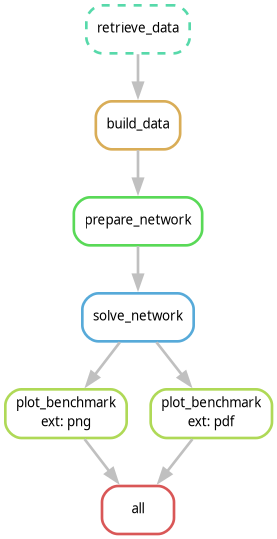

In [7]:
display(Image('dag_minimal.png'))

Alternatively, you can also visualize a filegraph like the figure above which includes also some information about the inputs and outputs to each of the rules.

You can reproduce the figure from above with the following command:
```
snakemake -call all --filegraph | dot -Tsvg > filegraph.svg
```

In [8]:
! snakemake -call all --filegraph | sed -n "/digraph/,\$p" | dot -Tsvg > filegraph_minimal.svg

Building DAG of jobs...


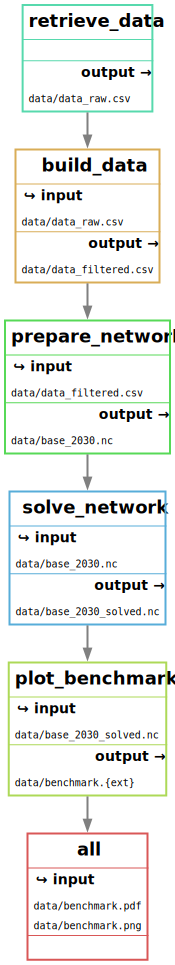

In [9]:
display(SVG('filegraph_minimal.svg'))

## Task 1: Executing a workflow with Snakemake

a) For our minimal example, execute a `dry-run` to produce the intermediate file `data/base_2030.nc`.

b) Execute the workflow and investigate what happens if you try to execute the workflow again.

c) Delete the final output files `data/benchmark.pdf` and investigate what happens if you try to execute the workflow again.

d) Import the raw input data file `data/data_raw.csv` using pandas and save it again overwriting the original file. Investigate what happens if you try to execute the workflow again. <br>
Hint: Alternative you can also just `touch` the file by executing `from pathlib import Path` and `Path("data/data_raw.csv").touch()`

e ) Finally, open the `Snakefile` and add a second rule that processes the file `data_raw_2.csv` using the same script as the `build_data` rule. Add the output of this new rule as a second input to the `prepare_network` rule.

## Using Snakemake to launch the open-TYNDP workflow

We have already retrieved a prebuilt version of the `open-tyndp` GitHub repository into our working directory...

The `open-tyndp` contains the following structure (directories which might be of particular interest to you are marked in bold):

- **benchmarks**: will store snakemake benchmarks (does not exist initially)
- **config**: configurations used in the study
- cutouts: will store raw weather data cutouts from atlite (does not exist initially)
- **data**: includes input data that is not produced by any snakemake rule. Various different input files are retrieved from external storage and stored in this directory
- doc: includes all files necessary to build the readthedocs documentation of PyPSA-Eur
- **envs**: includes all the mamba environment specifications to run the workflow
- logs: will store log files (does not exist initially)
- **notebooks**: includes all the notebooks used for ad-hoc analysis
- report: contains all files necessary to build the report; plots and result files are generated automatically
- **rules**: includes all the snakemake rules loaded in the Snakefile
- **resources**: will store intermediate results of the workflow which can be picked up again by subsequent rules (does not exist initially)
- **results**: will store the solved PyPSA network data, summary files and output plots (does not exist initially)
- **scripts**: includes all the Python scripts executed by the snakemake rules to build the model

## Task 2: Explore the folder

a) Can you find the TYNDP specific data input files?

b) Where can you verify the scenario and planning horizons used to produce the current results?

(hint: search for `config.tyndp.yaml`)

c) Can you find the hydrogen grid map in the outputs files for the NT scenario in 2040?

(hint: search for `base_s_all__-h2_network_2040.pdf`)

---


We now need to change our working directory to this new directory:

In [10]:
os.chdir('data/open-tyndp')

Let's check that we are indeed in the new directory now:

In [11]:
os.getcwd()

'/home/tgilon/Documents/oet/open-tyndp-workshops/open-tyndp-workshops/data/open-tyndp'

We can now use Snakemake to call some of the rules to produce outputs with the `open-tyndp` PyPSA model. 

We will use the prepared TYNDP configuration file (`config/config.tyndp.yaml`) and schedule a dry-run with `-n` as we only want to investigate the DAG of the workflow:

In [12]:
! snakemake -call all --configfile config/config.tyndp.yaml -n

Restricted license - for non-production use only - expires 2026-11-23
host: oet
Building DAG of jobs...
Job stats:
job                                                 count
------------------------------------------------  -------
add_electricity                                         1
add_existing_baseyear                                   1
add_transmission_projects_and_dlr                       1
all                                                     1
base_network                                            1
build_ammonia_production                                1
build_bidding_zones                                     1
build_biomass_potentials                                1
build_biomass_transport_costs                           1
build_central_heating_temperature_profiles              1
build_clustered_population_layouts                      1
build_cop_profiles                                      1
build_daily_heat_demand                                 1
build_direct_he

In [13]:
# Touch files to show snakemake logic

The corresponding rule graph to this workflow will look like this:

In [14]:
! snakemake -call all -F --rulegraph | sed -n "/digraph/,\$p" | dot -Tpng > rulegraph_open_tyndp.png

Building DAG of jobs...


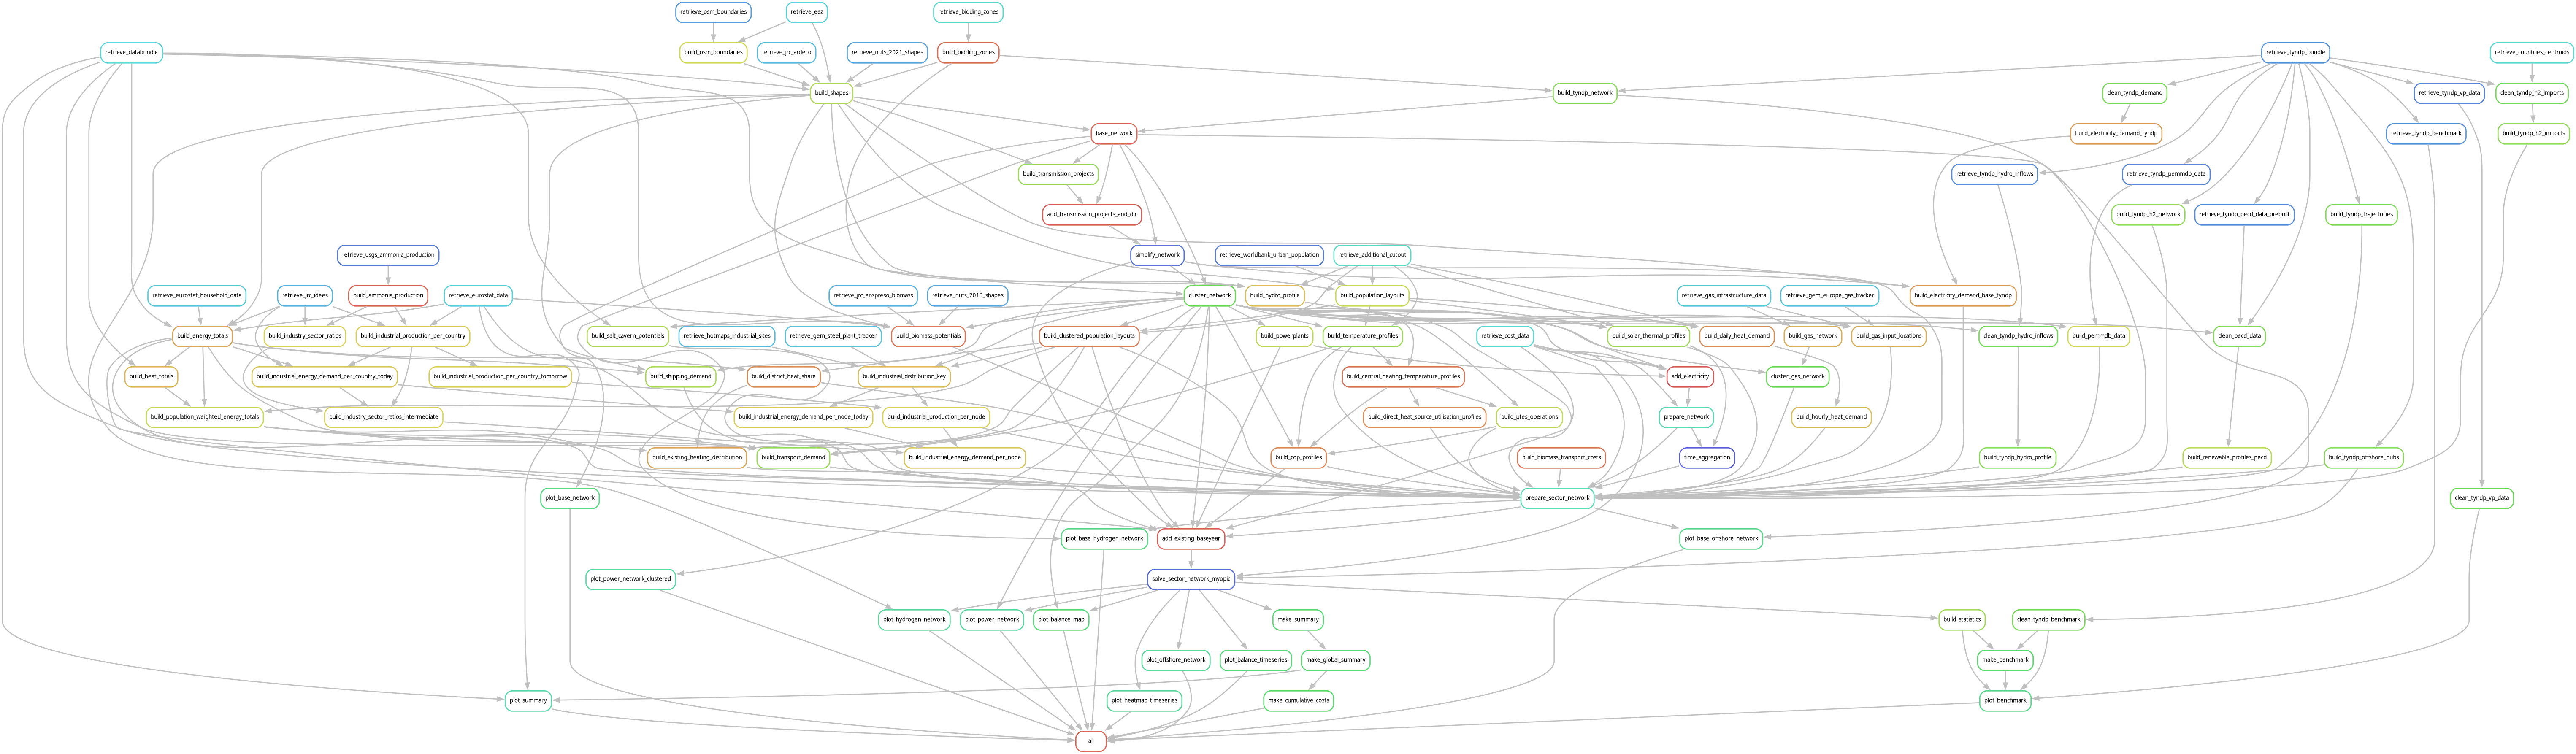

In [15]:
display(Image("rulegraph_open_tyndp.png"))

As you can see this workflow is much more complicated than our minimal example from the beginning.

However, the general idea remains the same. We retrieve data wich we consequently process, then we prepare the model network and we solve it before we postprocess the results (summary, plotting, benchmarks).

:::{note}
If you are executing this notebook on your local machine, you can also use the `conda` package manager to install the `open-tyndp` environment and run the workflow instead of dry-runs:
```
conda env create --file envs/<YourSystemOS>-pinned.yaml
```
:::

## Task 3: Adjusting the Open-TYNDP workflow with the configuration file

a) Make some changes in the configuration file and call another **dry-run** of the `open-tyndp` model again to see the changes to the workflow.

Disabling all sectors for instance, reduce the number of rules to be executed.

In [16]:
# TODO: Improve

In [17]:
! snakemake -call --configfile config/config.tyndp.yaml -n

Restricted license - for non-production use only - expires 2026-11-23
host: oet
Building DAG of jobs...
Job stats:
job                                                 count
------------------------------------------------  -------
add_electricity                                         1
add_existing_baseyear                                   1
add_transmission_projects_and_dlr                       1
all                                                     1
base_network                                            1
build_ammonia_production                                1
build_bidding_zones                                     1
build_biomass_potentials                                1
build_biomass_transport_costs                           1
build_central_heating_temperature_profiles              1
build_clustered_population_layouts                      1
build_cop_profiles                                      1
build_daily_heat_demand                                 1
build_direct_he

# Update on new features

For the purposes of this workshop, we will primarily focus on the National Trends (NT) scenario wherever it makes sense. Four major features were intruduced since our last workshop:
1. Addition of the electricity demand and PECD capacity factors time series,
2. Addition of onshore wind and solar TYNDP technologies (incl. PEMMDB existing capacities and trajectories),
3. Addition of offshore hubs (incl. the offshore topology, all associated technologies, potential constraints and trajectories),
4. Addition of hydrogen import corridors.

## Time Series

In [18]:
# look for renewables components
# Explain / remind difference between time varying and fixed attributes, how to access them
# Plot both time of parameters

The Open-TYNDP data we retrieved contains low time resolution network. This is illustrative, however, since we are focusing on time series, we will use another higher resolution network. So, we will import an high resolution pre-solved network for the National Trends (NT) scenario for 2030

In [19]:
# hourly networks
n_2030_NT_presolve_highres = pypsa.Network("../network_NT_presolve_highres_2030.nc")

INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


## Electricity demand

We can then explore the electricity demand that is attached to the network. Can you remember how to access `Loads` timeseries in PyPSA?

Correct! You can use the `loads_t` key and its `p_set` attribute:

In [20]:
loads_2030 = n_2030_NT_presolve_highres.loads_t.p_set
loads_2030.head()

Load,AL00,AT00,BA00,BE00,BG00,CH00,CY00,CZ00,DE00,DKE1,...,PL00,PT00,RO00,RS00,SE01,SE02,SE03,SE04,SI00,SK00
snapshot,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,947.959412,9823.934937,1139.898666,12242.365509,5565.920746,7166.768456,514.413109,7134.304718,75929.264656,2167.298187,...,17104.075562,6068.504311,6906.502472,7191.248100,1653.199226,2470.068657,11584.612106,3193.297096,1356.612617,2899.493263
2009-01-01 01:00:00,833.057487,9821.063911,1086.608055,11888.769669,5414.886581,6796.788185,500.234436,7121.448853,73368.054413,2089.113052,...,16892.143913,5704.324791,6925.691902,6284.783302,1652.897522,2457.466545,11492.949509,3166.825447,1335.408936,3076.165970
2009-01-01 02:00:00,764.375237,9742.805717,1035.842484,11542.755981,5312.423264,6770.658478,491.265236,7024.643143,72445.216782,2038.800095,...,16826.266251,5277.870186,7063.218033,5642.247635,1648.209999,2433.868546,11348.999016,3118.911705,1323.218330,2980.385391
2009-01-01 03:00:00,732.734497,9807.876175,1011.463104,11343.939415,5259.545975,6653.832253,508.105309,6944.713936,73673.191757,2032.129326,...,17360.237389,5090.429459,7446.547157,5022.270302,1649.819946,2428.670639,11205.289032,3069.691803,1330.600349,3013.437683
2009-01-01 04:00:00,738.262611,9821.234138,1004.053360,11586.468903,5135.470093,6915.888031,555.610298,6776.687698,77914.759674,2045.791275,...,16662.134514,5030.606117,8229.326569,4536.644714,1671.352608,2452.380264,11084.080399,3037.241516,1424.730194,3260.762955


Let's plot these electricity demand time series:

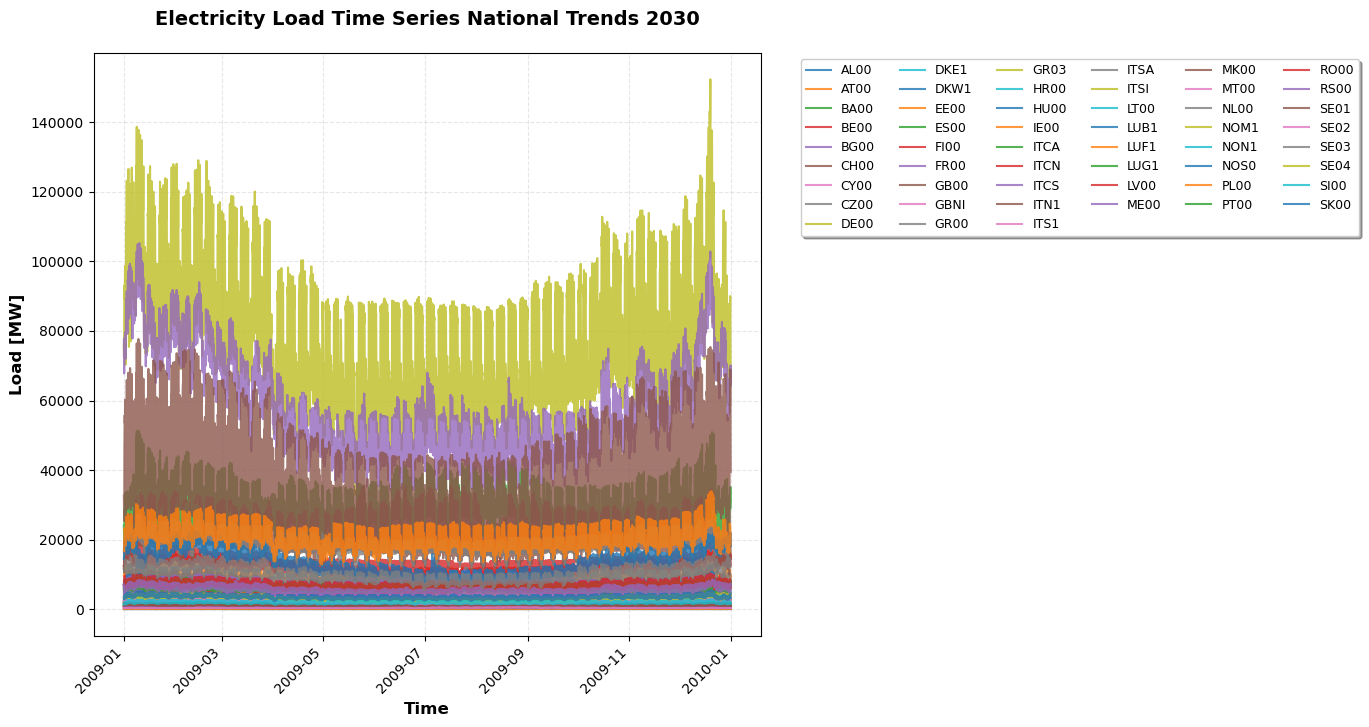

In [21]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each load time series
for load in loads_2030.columns:
    ax.plot(loads_2030.index, loads_2030[load], label=load, linewidth=1.5, alpha=0.8)

# Formatting
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Load [MW]", fontsize=12, fontweight='bold')
ax.set_title("Electricity Load Time Series National Trends 2030", fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          frameon=True, shadow=True, fontsize=9, ncols=6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right');

This is very confusing to look at. Let's filter that down a bit...

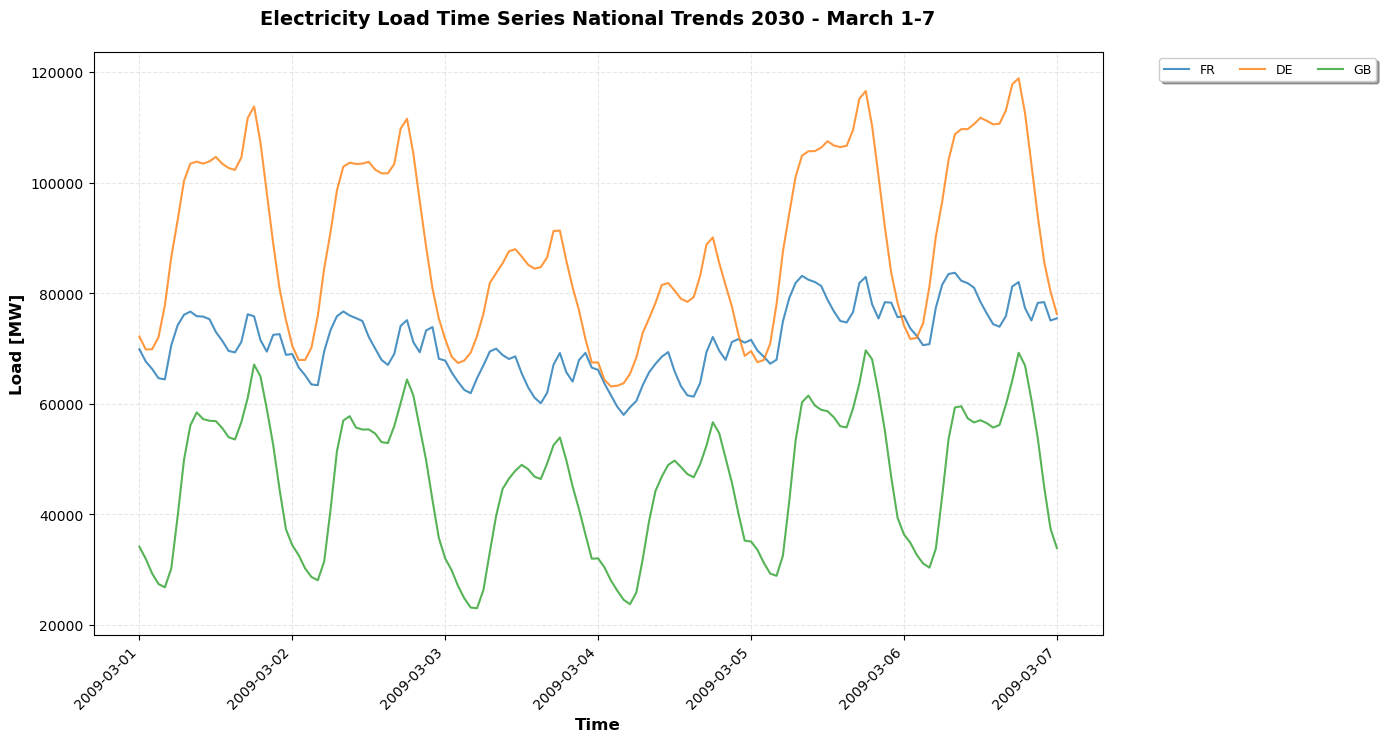

In [22]:
# group country profiles together
country_mapping = n_2030_NT_presolve_highres.buses.query("carrier=='AC'").country
loads_2030_by_country = (
    n_2030_NT_presolve_highres
    .loads_t
    .p_set.T
    .rename(country_mapping, axis=0)
    .groupby("Load").sum().T
    .query("index  >= '2009-03-01' and index <= '2009-03-07'")
    [['FR', 'DE', 'GB']]
)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each load time series
for load in loads_2030_by_country.columns:
    ax.plot(loads_2030_by_country.index, loads_2030_by_country[load], label=load, linewidth=1.5, alpha=0.8)

# Formatting
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Load [MW]", fontsize=12, fontweight='bold')
ax.set_title("Electricity Load Time Series National Trends 2030 - March 1-7", fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          frameon=True, shadow=True, fontsize=9, ncols=6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right');

## Task 4: Use PyPSA statistics to explore the load

Can you remember how to use the **PyPSA Statistics** module that we introduced in the last workshop to interactively visualize these electricity demand inputs from the network:

First we need to load a lower resolution network that was solved, so we can use the statistics module to analyse it.

In [23]:
n_2030_NT_solved_lowres = pypsa.Network("results/tyndp/NT/networks/base_s_all___2030.nc")
n_2030_NT_solved_lowres.carriers.loc["none", "color"] = "#000000"
n_2030_NT_solved_lowres.carriers.loc["", "color"] = "#000000"

n_2040_DE_solved_lowres = pypsa.Network("results/tyndp/DE/networks/base_s_all___2040.nc")
n_2040_DE_solved_lowres.carriers.loc["none", "color"] = "#000000"
n_2040_DE_solved_lowres.carriers.loc["", "color"] = "#000000"

INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores
INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


In [24]:
# let's define a helper variable
s = n_2030_NT_solved_lowres.statistics

Let's access the data using `s.withdrawal()`.

In [25]:
s.withdrawal(
    bus_carrier="low voltage",
    comps="Load",
    aggregate_time=False,
    groupby=False
).T.head()

Load,AL00,AT00,BA00,BE00,BG00,CH00,CY00,CZ00,DE00,DKE1,...,PL00,PT00,RO00,RS00,SE01,SE02,SE03,SE04,SI00,SK00
snapshot,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1292.262,12056.696,1570.536,15702.039,5727.378,9700.828,664.347,11019.461,106034.763,2651.625,...,23935.166,7138.344,8146.713,6851.188,1686.402,2562.599,12885.822,3833.582,2198.051,4148.384
2009-01-13 14:00:00,1188.937,11450.222,1588.031,14582.414,5288.742,9326.399,622.567,10686.816,96450.120,2483.092,...,23620.925,7010.229,7833.112,7051.831,1715.278,2649.814,12912.344,3773.550,2234.345,4141.076
2009-01-23 09:00:00,1140.783,11484.248,1585.403,15192.279,4769.468,9548.749,636.675,10522.683,100120.773,2543.794,...,22953.322,6812.129,7399.027,6885.462,1695.069,2644.253,12607.831,3832.334,2269.994,4050.267
2009-01-30 09:00:00,1129.869,11516.220,1509.984,15173.118,4827.856,9358.197,629.842,10479.584,98924.388,2448.525,...,24210.592,7077.114,7610.870,6572.857,1734.779,2806.575,13096.664,3894.604,2255.453,4039.205
2009-02-07 14:00:00,1123.896,11331.681,1484.994,14671.487,4669.276,9450.420,607.794,10446.549,97417.096,2419.843,...,23724.969,6674.885,7559.813,6511.809,1809.294,2893.477,12960.405,3863.415,2116.517,3966.273


We can also plot all the countries at the same time...

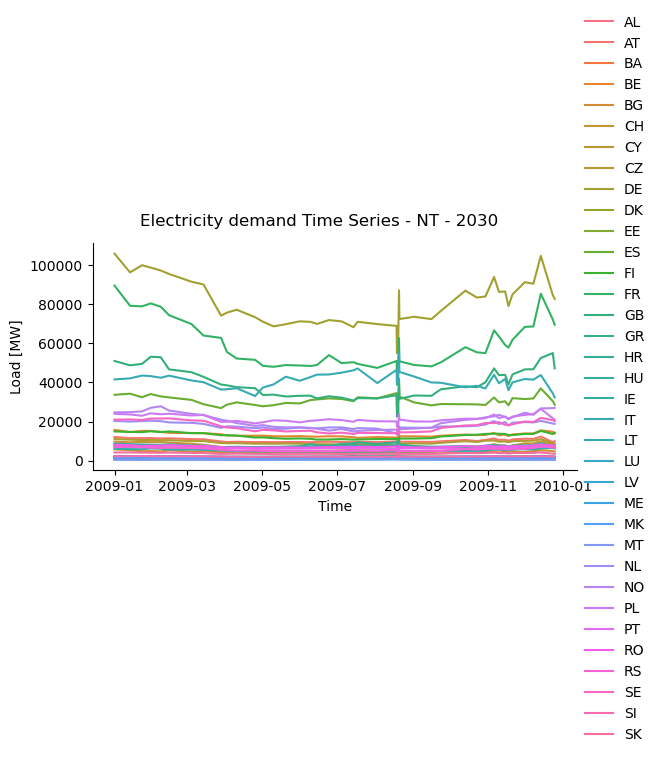

In [26]:
fig, ax, facet_col  = s.withdrawal.plot.line(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="country",
)
fig.suptitle('Electricity demand Time Series - NT - 2030', y=1.05)
ax.set_ylabel("Load [MW]")
ax.set_xlabel("Time");

This is again difficult to read. Let's keep only two countries.

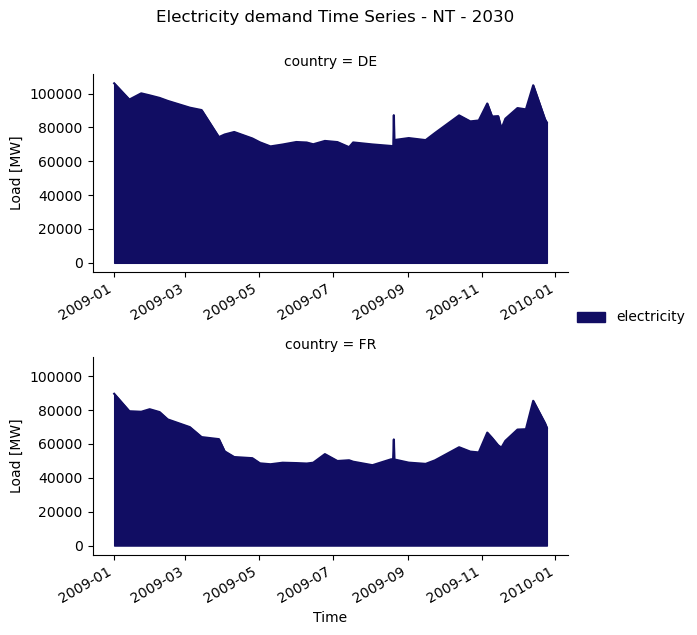

In [27]:
fig, ax, facet_col  = s.withdrawal.plot.area(
    bus_carrier="low voltage",
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="country",
    query="carrier == 'electricity' and country in ['DE', 'FR']",
)
fig.suptitle('Electricity demand Time Series - NT - 2030', y=1.05)
ax[0,0].set_ylabel("Load [MW]")
ax[1,0].set_ylabel("Load [MW]")
ax[1,0].set_xlabel("Time");

## PECD capacity factors

The Pan European Climate Database (PECD) provides capacity factor profiles for all the different renewable technologies used in the TYNDP. We processed these input data files into a Python and PyPSA friendly input format.

Let's start by looking at the processed capacity factor time series for solar PV Utility for 2030. Those processed data are stored in the `resources`, as this is an output `build_renewable_profiles_pecd`. We will filter the data to a set of countries and a week.

In [28]:
cf_pv_rftp = pd.read_csv(
    "resources/tyndp/NT/pecd_data_LFSolarPVRooftop_2030.csv",
    index_col=0,
    parse_dates=True,
).loc['2009-07-01':'2009-07-04', ["SE04", "DE00", "FR00", "ES00"]]
cf_pv_rftp.head()

,SE04,DE00,FR00,ES00
2009-07-01 00:00:00,0.000000,0.000000,0.000000,0.0
2009-07-01 01:00:00,0.000000,0.000000,0.000000,0.0
2009-07-01 02:00:00,0.000000,0.000000,0.000000,0.0
2009-07-01 03:00:00,0.000675,0.000000,0.000000,0.0
2009-07-01 04:00:00,0.025404,0.014742,0.000006,0.0


Using an heatmap, we can better grasp the content of the data.

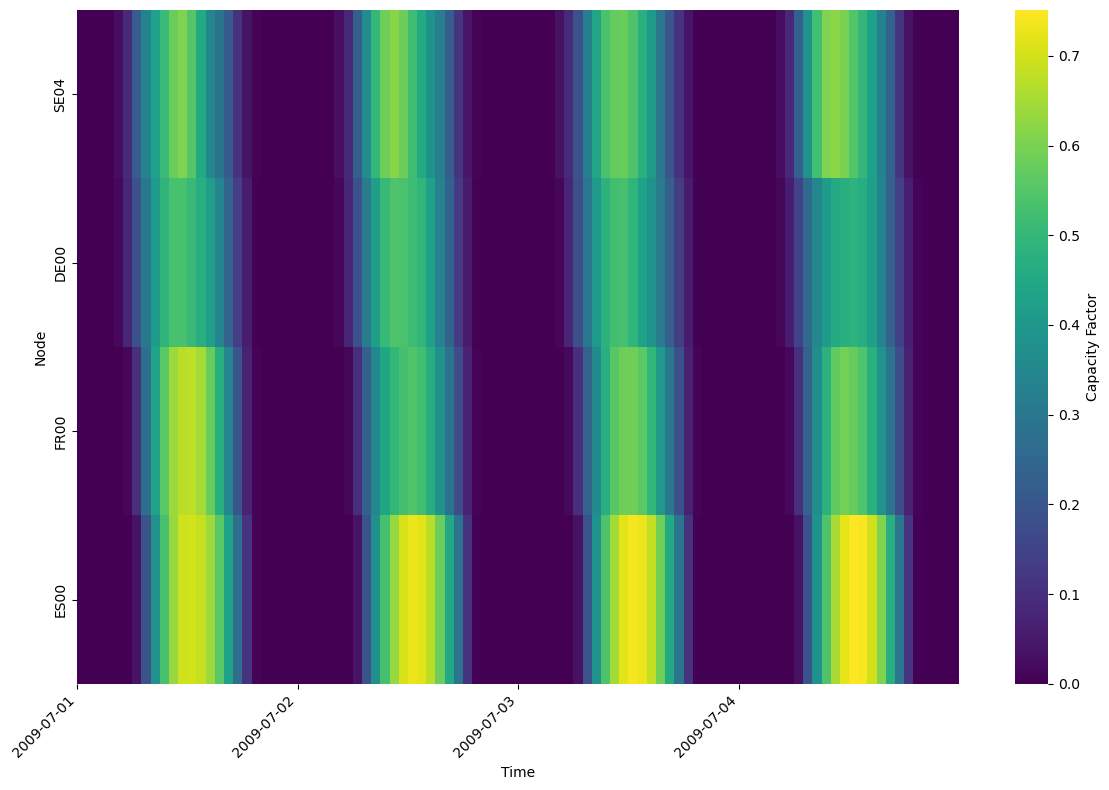

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    cf_pv_rftp.T, 
    cmap='viridis', 
    cbar_kws={'label': 'Capacity Factor'}, 
    ax=ax
)

tick_positions = range(0, len(cf_pv_rftp), 24)
ax.set_xticks(tick_positions)
ax.set_xticklabels(cf_pv_rftp.index[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

ax.set_xlabel('Time')
ax.set_ylabel('Node')
plt.tight_layout()
plt.show()

We can also present the data as time series.

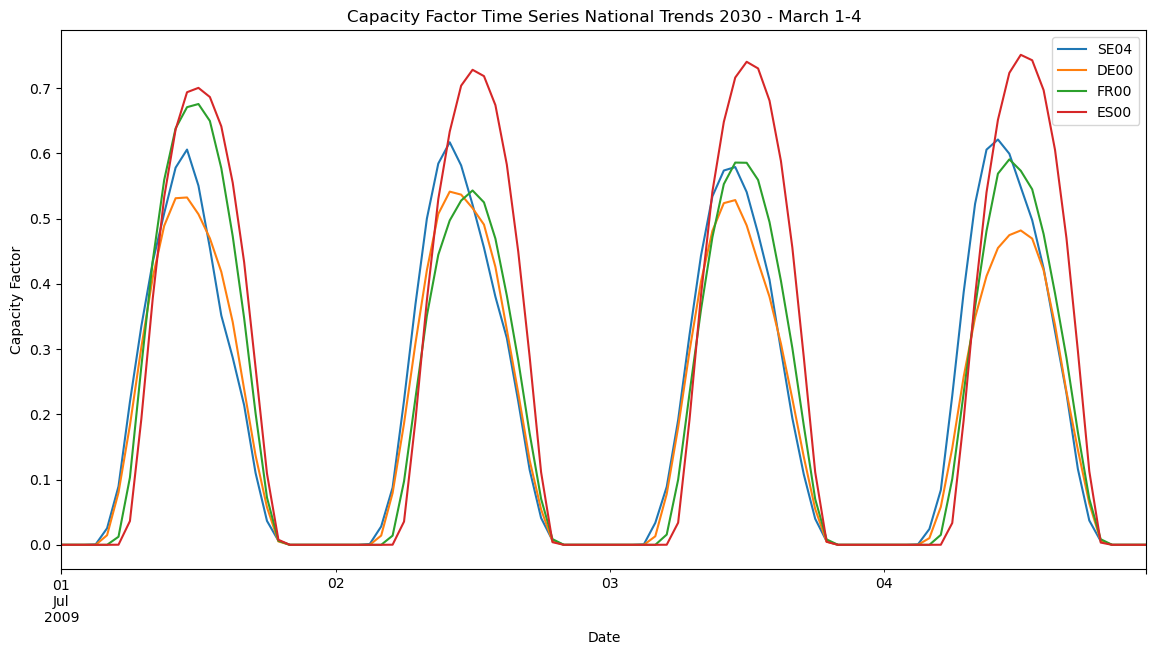

In [30]:
fig, ax = plt.subplots(figsize=(14, 7))

cf_pv_rftp.plot(
    title="Capacity Factor Time Series National Trends 2030 - March 1-4",
    xlabel="Date",
    ylabel="Capacity Factor",
    ax=ax,
);

In [31]:
# Task: In the open-tyndp, offshore wind, onshore wind and solar RES are added to the model at this time. 
# Take some time to investigate the network and find the corresponding capacity factor time series.
# Hint: Capacity factors are implemented in PyPSA by using the per unit dispatch limit (`p_min_pu`)

## Onshore wind and solar

The TYNDP provides expansion trajectories for given investment candidates and expandable technologies. For the implemented Onshore wind and solar technologies, this has been included within this beta release v0.3 of the Open-TYNDP model.

It is possible to retrieve those values from the network. However, for simplicity reasons, we will import the values from the processed input files for the `DE` scenario directly to investigate the entire trajectory paths at once.

In [32]:
trajectories = pd.read_csv("resources/tyndp/DE/tyndp_trajectories.csv")
trajectories.head()

,carrier,index_carrier,bus,scenario,pyear,p_nom_min,p_nom_max
0,nuclear,nuclear,AL00,DE,2030,0.0,0.0
1,nuclear,nuclear,AL00,DE,2035,0.0,0.0
2,nuclear,nuclear,AL00,DE,2040,0.0,0.0
3,nuclear,nuclear,AL00,DE,2045,0.0,0.0
4,nuclear,nuclear,AL00,DE,2050,0.0,0.0


Similar to the capacity factor time series, we want to focus on the Solar PV Rooftop technology and their trajectory path. Let's take Germany (DE00) to investigate

In [33]:
trajectories_pv_utility_de = (
    trajectories
    .query("carrier == 'solar-pv-rooftop' and bus == 'DE00'")
    .sort_values(by="pyear")
    .set_index("pyear")
    [["p_nom_min", "p_nom_max"]]
    .div(1e3)  # GW
)
trajectories_pv_utility_de

,p_nom_min,p_nom_max
pyear,,
2030,117.998902,117.998902
2035,155.874355,164.909835
2040,193.749808,211.820767
2045,202.028557,239.258360
2050,210.307306,266.695952


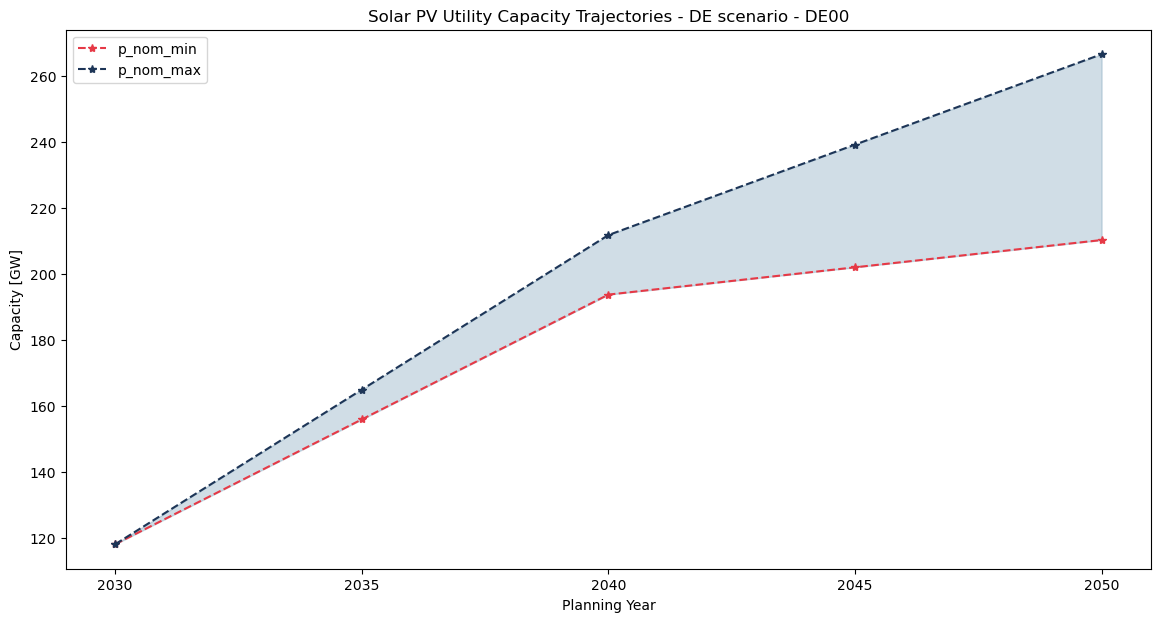

In [34]:
fig, ax = plt.subplots(figsize=(14, 7))
trajectories_pv_utility_de.plot(
    title="Solar PV Utility Capacity Trajectories - DE scenario - DE00",
    xlabel="Planning Year",
    ylabel="Capacity [GW]",
    color=['#E63946', '#1D3557'],
    style='*--',
    ax=ax
);

ax.fill_between(
    trajectories_pv_utility_de.index,
    trajectories_pv_utility_de.iloc[:, 0],
    trajectories_pv_utility_de.iloc[:, 1],
    alpha=0.25,
    color='#457B9D',
    label='Trajectory Range'
)

ax.xaxis.set_major_locator(MultipleLocator(5))

Now, let's access the network of the DE scenario to compare one of these values for 2040.

In [35]:
# TODO: include DE scenarios in open-tyndp.zip
n_2040_DE_solved_lowres = pypsa.Network("results/tyndp/DE/networks/base_s_all___2040.nc")

INFO:pypsa.network.io:Imported network 'PyPSA-Eur (tyndp)' has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


In [36]:
trajectories_pv_utility_de_from_network = (
    n_2040_DE_solved_lowres
    .generators
    .query("carrier == 'solar-pv-utility' and bus == 'DE00'")
    [["p_nom", "p_nom_min", "p_nom_max"]]
    .div(1e3)  # in GW
)
trajectories_pv_utility_de_from_network

,p_nom,p_nom_min,p_nom_max
Generator,,,
DE00 0 solar-pv-utility-2040,75.124282,75.124094,91.178135
DE00 0 solar-pv-utility-2030,97.001098,97.001098,97.001098


As we can see, the `p_nom_max` and `p_nom_min` values for 2040 do not match directly with the reported trajectories value analysed above. This is because each new Generator will have set trajectories that correspond to the new cummulatively installed capacities taking into account optimization results from previous years. So if we add up the existing capacity (`p_nom`) from 2030 and `p_nom_max` and `p_nom_min` from 2040, we will find the reported trajectory values from before again:

In [37]:
trajectories_pv_utility_de_from_network.loc["DE00 0 solar-pv-utility-2040", ["p_nom_min", "p_nom_max"]] + trajectories_pv_utility_de_from_network.loc["DE00 0 solar-pv-utility-2030", "p_nom"]

p_nom_min    172.125192
p_nom_max    188.179233
Name: DE00 0 solar-pv-utility-2040, dtype: float64

In [38]:
# Task: Reproduce this exercise for Onshore Wind. You can copy and reuse the existing code used above.

## Offshore Hubs

To implement the offshore methodology, new carriers (read: *technologies*) are introduced. All the offshore technologies start with `offwind`.

In [39]:
offwind_carriers = n_2030_NT_solved_lowres.carriers.query("Carrier.str.contains('offwind')")
offwind_carriers_i = offwind_carriers.index
offwind_carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
offwind-h2-fb-oh,0.0,#c47dbd,offwind-h2-fb-oh,inf,0.0
offwind-dc-fl-r,0.0,#94d4f6,offwind-dc-fl-r,inf,0.0
offwind-dc-fb-oh,0.0,#74c6f2,offwind-dc-fb-oh,inf,0.0
offwind-ac-fl-r,0.0,#6da5e8,offwind-ac-fl-r,inf,0.0
offwind-dc-fl-oh,0.0,#b5e2fa,offwind-dc-fl-oh,inf,0.0
offwind-ac-fb-r,0.0,#6895dd,offwind-ac-fb-r,inf,0.0
offwind-dc-fb-r,0.0,#71b5ed,offwind-dc-fb-r,inf,0.0
offwind-h2-fl-oh,0.0,#9d4d96,offwind-h2-fl-oh,inf,0.0


As you can see, all the offshore technologies are implemented. We model technologies that are a combination of the following:
- both AC `ac` and DC `dc` zones, as well as H2 generating windfarms `h2`;
- both fixed-bottom `fb` and floating `fl` foundations;
- both radial `r` and hub `oh` connections.

We also introduce new offshore buses, both for Electricity and Hydrogen. Electricity buses use `AC_OH` as carrier, while hydrogen buses use `H2_OH`.

In [40]:
n_2030_NT_solved_lowres.buses.query("carrier.str.contains('OH')").head()

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off
Bus,,,,,,,,,,,,,,,,
BEIOH01,380.0,Hub,15.199463,55.095104,AC_OH,MWh_el,BEIOH01,1.0,0.0,inf,PQ,,,BE,NaN,NaN
BEOH001,380.0,Hub,2.706047,51.466411,AC_OH,MWh_el,BEOH001,1.0,0.0,inf,PQ,,,BE,NaN,NaN
DEOH001,380.0,FarShoreHub,6.236433,54.812295,AC_OH,MWh_el,DEOH001,1.0,0.0,inf,PQ,,,DE,NaN,NaN
DEOH002,380.0,Hub,13.272319,54.471376,AC_OH,MWh_el,DEOH002,1.0,0.0,inf,PQ,,,DE,NaN,NaN
DKWOH01,380.0,FarShoreHub,5.991189,56.185492,AC_OH,MWh_el,DKWOH01,1.0,0.0,inf,PQ,,,DK,NaN,NaN


Let's narrow down this list for a single country.

In [41]:
buses = n_2030_NT_solved_lowres.buses.query("carrier.str.contains('OH') and country=='BE'")
buses_i = buses.index
buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off
Bus,,,,,,,,,,,,,,,,
BEIOH01,380.0,Hub,15.199463,55.095104,AC_OH,MWh_el,BEIOH01,1.0,0.0,inf,PQ,,,BE,NaN,NaN
BEOH001,380.0,Hub,2.706047,51.466411,AC_OH,MWh_el,BEOH001,1.0,0.0,inf,PQ,,,BE,NaN,NaN
BEIOH01 H2,1.0,Hub,15.199463,55.095104,H2_OH,MWh_LHV,BEIOH01,1.0,0.0,inf,PQ,,,BE,NaN,NaN
BEOH001 H2,1.0,Hub,2.706047,51.466411,H2_OH,MWh_LHV,BEOH001,1.0,0.0,inf,PQ,,,BE,NaN,NaN


Using the `n.plot.explore()`, we can easily get an overview of the network topology. Let's clean the network before exploring it to only focus on the electrical offshore topology.

In [42]:
# let's filter AC_OH buses and explore
n_explore_ac = n_2030_NT_solved_lowres.copy()
n_explore_ac.remove("Bus", n_explore_ac.buses.query("carrier not in ['AC_OH']").index)
n_explore_ac.plot.explore()

INFO:pypsa.plot.maps.interactive:Omitting 1824 links due to missing coordinates.
INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer


Now, we can search in the network for generators that are defined on those carriers.

In [43]:
n_2030_NT_solved_lowres.generators.query("carrier in @offwind_carriers_i").head()

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,efficiency_dc_to_b0,efficiency_dc_to_h2
Generator,,,,,,,,,,,,,,,,,,,,,
DEOH001 0 offwind-dc-fb-oh-2030,DEOH001,PQ,,18868.000000,0.0,False,18868.000000,62868.000000,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,18868.000000,1.0,0.68
NLOR001 0 offwind-dc-fb-r-2030,NL00,PQ,,14300.000000,0.0,False,14300.000000,29421.362456,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,14300.000000,1.0,0.68
PLOH001 0 offwind-ac-fb-r-2030,PL00,PQ,,9380.015208,0.0,False,9380.015208,9380.015208,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,9380.015208,1.0,0.68
GBOR001 0 offwind-ac-fb-r-2030,GB00,PQ,,8975.976664,0.0,False,8975.976664,8975.976664,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,8975.976664,1.0,0.68
GBOR001 0 offwind-dc-fb-r-2030,GB00,PQ,,8528.778032,0.0,False,8528.778032,22023.495767,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,8528.778032,1.0,0.68


Let's focus on the country of your choice:

In [44]:
n_2030_NT_solved_lowres.generators.query("carrier in @offwind_carriers_i and bus in @buses_i")

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,efficiency_dc_to_b0,efficiency_dc_to_h2
Generator,,,,,,,,,,,,,,,,,,,,,
BEIOH01 0 offwind-dc-fb-oh-2030,BEIOH01,PQ,,3000.000000,0.0,False,3000.000000,12815.264163,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,3000.000000,1.00,0.68
BEOH001 0 offwind-dc-fb-oh-2030,BEOH001,PQ,,2647.515945,0.0,False,2647.515945,4847.515945,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,2647.515945,1.00,0.68
BEIOH01 0 offwind-h2-fb-oh-2030,BEIOH01 H2,PQ,,0.000000,0.0,False,0.000000,8714.379631,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.000000,0.68,0.68
BEOH001 0 offwind-h2-fb-oh-2030,BEOH001 H2,PQ,,0.000000,0.0,False,0.000000,3296.310843,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.000000,0.68,0.68


Exercise: Can you extract the existing offshore capacities of your home country for the DE scenario in 2040?

In [45]:
n_2040_DE_solved_lowres.statistics.optimal_capacity(
    bus_carrier=["AC", "AC_OH", "H2_OH"],
    comps="Generator",
    groupby=["bus"],
).to_frame().query("bus.str.contains('BE')")

,0
bus,
BE00,29671.500
BEIOH01,3000.002
BEIOH01 H2,0.001
BEOH001,4847.516


In [46]:
n_2040_DE_solved_lowres.carriers.loc["none", "color"] = "#000000"
n_2040_DE_solved_lowres.carriers.loc["", "color"] = "#000000"

In [47]:
n_2040_DE_solved_lowres.statistics.optimal_capacity.iplot.bar(
    bus_carrier=["AC", "AC_OH", "H2_OH"],
    query="carrier.str.startswith('offwind') and country in ['NL', 'GB']",
    facet_col="country",
)

In [48]:
# Explore with maps

In [49]:
n_map = n_2040_DE_solved_lowres.copy()
n_map.remove("Bus", n_map.buses.query("carrier not in ['AC', 'AC_OH']").index)
n_map.remove("Generator", n_map.generators.query("not carrier.str.startswith('offwind')").index)
n_map.remove("Link", n_map.links.index)
n_map.remove("StorageUnit", n_map.storage_units.index)

In [50]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


proj = load_projection(dict(name="EqualEarth"))

/home/tgilon/micromamba/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/plot/statistics/maps.py:214: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend circle sizes.

/home/tgilon/micromamba/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/plot/statistics/maps.py:214: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend circle sizes.



(<Figure size 1200x1200 with 2 Axes>, <GeoAxes: >)

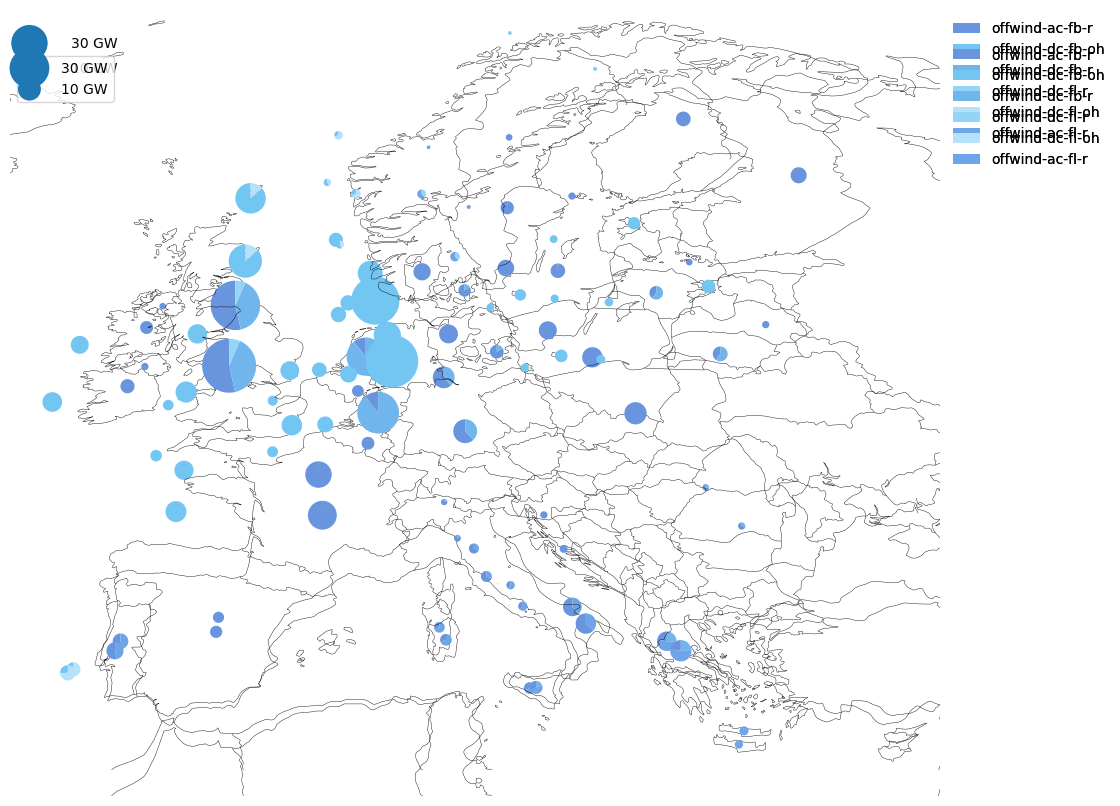

In [51]:
subplot_kw = {"projection": proj}
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=subplot_kw)
n_map.statistics.optimal_capacity.plot.map(
    bus_carrier=["AC", "AC_OH"],
    ax=ax,
    bus_area_fraction=0.007,
    flow_area_fraction=0.004,
    legend_circles_kw=dict(
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
    ),
    legend_arrows_kw=dict(
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
    ),
);
n_map.statistics.optimal_capacity.plot.map(
    bus_carrier=["AC", "AC_OH"],
    bus_area_fraction=0.007,
)

As you can see, generators are not expandable because we currently use an NT scenario. However, they are expandable for the DE and GA scenario. Let's check in the network.

In [52]:
n_2040_DE_solved_lowres.generators.query("carrier in @offwind_carriers_i")[["p_nom", "p_nom_min", "p_nom_max", "p_nom_opt", "p_nom_extendable"]]

,p_nom,p_nom_min,p_nom_max,p_nom_opt,p_nom_extendable
Generator,,,,,
DEOH001 0 offwind-dc-fb-oh-2040,33600.000000,33600.000000,44000.000000,33600.000000,True
NLOR001 0 offwind-dc-fb-r-2040,15121.362456,15121.362456,15121.362456,15121.362456,True
GBOR001 0 offwind-dc-fb-r-2040,13494.717610,13494.717610,13494.717610,13494.717610,True
GBOH006 0 offwind-dc-fb-oh-2040,11442.295730,11442.295730,11442.295730,11442.295730,True
DKWOH01 0 offwind-dc-fb-oh-2040,14000.000000,14000.000000,59983.343624,14000.000020,True
...,...,...,...,...,...
FROH003 0 offwind-ac-fb-r-2030,85.000205,85.000000,2266.539491,85.000205,False
NOSOR01 0 offwind-ac-fb-r-2030,65.472998,65.472998,65.472998,65.472998,False
NOSOR01 0 offwind-dc-fb-r-2030,29.154858,29.154858,29.154858,29.154858,False


We also implemented constraints to ensure to respect the potential defined in the data. Two types of constraints are implemented:
- potential limitations
- trajectories limitations

In [53]:
# exercise

## H2 imports

In [54]:
# read network
# plot H2 map with import corridors
# table to showcase the corridors
# optional: Task to investigate values

There have also been some important additions to H2 infrastructure since our last workshop. The different H2 import corridors are now included in the model with a simple pipeline transport model representation such as for H2 reference grid.

We can investigate our National Trends network from before to find a similar plot we showed last time. Let's define some (quite extensive) plotting functions from the open-tyndp workflow:

In [55]:
def group_import_corridors(df):
    """
    Group pipes which connect same buses and return overall capacity.
    """
    df = df.copy()

    # there are pipes for each investment period rename to AC buses name for plotting
    df["index_orig"] = df.index
    df.rename(index=lambda x: x.split(" - ")[0], inplace=True)
    return df.groupby(level=0).agg(
        {"p_nom": "sum", "p_nom_opt": "sum", "index_orig": "first"}
    )


def plot_h2_map_base(
    network, 
    map_opts, 
    proj,
    figsize=(12, 12), 
    expanded=False, 
    regions_for_storage=None,     
    color_h2_pipe = "#499a9c",
    color_h2_imports = "#FFA500",
    color_h2_node = "#ff29d9",
):
    """
    Plots the base hydrogen network pipelines capacities, hydrogen buses and import potentials.
    If expanded is enabled, the optimal capacities are plotted instead.
    If regions are given, hydrogen storage capacities are plotted for those regions with aggregated H2 tank storage
    and underground H2 cavern capacities.

    Parameters
    ----------
    network : pypsa.Network
        PyPSA network for plotting the hydrogen grid. Can be either presolving or post solving.
    map_opts : dict
        Map options for plotting.
    expanded : bool, optional
        Whether to plot expanded capacities. Defaults to plotting only base network (p_nom).
    regions_for_storage : gpd.GeoDataframe, optional
        Geodataframe of regions to use for plotting hydrogen storage capacities. Index needs to match storage locations.
        If none is given, no hydrogen storage capacities are plotted.

    Returns
    -------
    None
        Saves the map plot as figure.
    """
    n = network.copy()

    linewidth_factor = 4e3

    n.links.drop(
        n.links.index[
            ~(
                n.links.carrier.str.contains("H2 pipeline")
                | n.links.carrier.str.contains("H2 import")
            )
        ],
        inplace=True,
    )
    n.links.drop(
        n.links.index[n.links.carrier.str.contains("OH")],
        inplace=True,
    )

    p_nom = "p_nom_opt" if expanded else "p_nom"
    # capacity of pipes and imports
    h2_pipes = n.links[n.links.carrier == "H2 pipeline"][p_nom]
    h2_imports = n.links[n.links.carrier.str.contains("H2 import")]

    # group high and low import corridors together
    h2_imports = group_import_corridors(h2_imports)[p_nom]
    n.links.rename(index=lambda x: x.split(" - ")[0], inplace=True)
    # group links by summing up p_nom values and taking the first value of the rest of the columns
    other_cols = dict.fromkeys(n.links.columns.drop(["p_nom_opt", "p_nom"]), "first")
    n.links = n.links.groupby(level=0).agg(
        {"p_nom_opt": "sum", "p_nom": "sum", **other_cols}
    )

    # set link widths
    link_widths_pipes = h2_pipes / linewidth_factor
    link_widths_imports = h2_imports / linewidth_factor
    if link_widths_pipes.notnull().empty:
        print("No base H2 pipeline capacities to plot.")
        return
    link_widths_pipes = link_widths_pipes.reindex(n.links.index).fillna(0.0)
    link_widths_imports = link_widths_imports.reindex(n.links.index).fillna(0.0)

    # drop non H2 buses
    n.buses.drop(
        n.buses.index[
            (~n.buses.carrier.str.contains("H2")) | (n.buses.carrier.str.contains("OH"))
        ],
        inplace=True,
    )

    # optionally add hydrogen storage capacities onto the map
    if regions_for_storage is not None:
        h2_storage = n.stores.query("carrier.str.contains('H2')")
        regions_for_storage["H2"] = (
            h2_storage.rename(index=h2_storage.bus.map(n.buses.location))
            .e_nom_opt.groupby(level=0)
            .sum()
            .div(1e6)
        )  # TWh
        regions_for_storage["H2"] = regions_for_storage["H2"].where(
            regions_for_storage["H2"] > 0.1
        )

    # plot H2 pipeline capacities and imports
    print("Plotting base H2 pipeline and import capacities.")
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})

    n.plot.map(
        geomap=True,
        bus_sizes=0.1,
        bus_colors=color_h2_node,
        link_colors=color_h2_pipe,
        link_widths=link_widths_pipes,
        branch_components=["Link"],
        ax=ax,
        **map_opts,
    )

    if regions_for_storage is not None:
        regions_for_storage = regions_for_storage.to_crs(proj.proj4_init)
        regions_for_storage.plot(
            ax=ax,
            column="H2",
            cmap="Blues",
            linewidths=0,
            legend=True,
            vmax=6,
            vmin=0,
            legend_kwds={
                "label": "Hydrogen Storage [TWh]",
                "shrink": 0.7,
                "extend": "max",
            },
        )

    if not h2_imports.empty:
        n.plot.map(
            geomap=True,
            bus_sizes=0,
            link_colors=color_h2_imports,
            link_widths=link_widths_imports,
            branch_components=["Link"],
            ax=ax,
            **map_opts,
        )

    sizes = [30, 10]
    labels = [f"{s} GW" for s in sizes]
    scale = 1e3 / linewidth_factor
    sizes = [s * scale for s in sizes]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.32, 1.13),
        frameon=False,
        ncol=1,
        labelspacing=0.8,
        handletextpad=1,
    )

    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color="lightgrey"),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.55, 1.13),
        labelspacing=0.8,
        handletextpad=0,
        frameon=False,
    )

    add_legend_circles(
        ax,
        sizes=[0.2],
        labels=["H2 Node"],
        srid=n.srid,
        patch_kw=dict(facecolor=color_h2_node),
        legend_kw=legend_kw,
    )

    colors = (
        [color_h2_pipe, color_h2_imports] if not h2_imports.empty else [color_h2_pipe]
    )
    labels = ["H2 Pipeline", "H2 import"] if not h2_imports.empty else ["H2 Pipeline"]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0, 1.13),
        ncol=1,
        frameon=False,
    )

    add_legend_patches(ax, colors, labels, legend_kw=legend_kw)

    ax.set_facecolor("white")

    plt.show()

And plot the H2 reference grid together with the import corridors:

/tmp/ipykernel_3438144/182598603.py:184: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend circle sizes.



Plotting base H2 pipeline and import capacities.


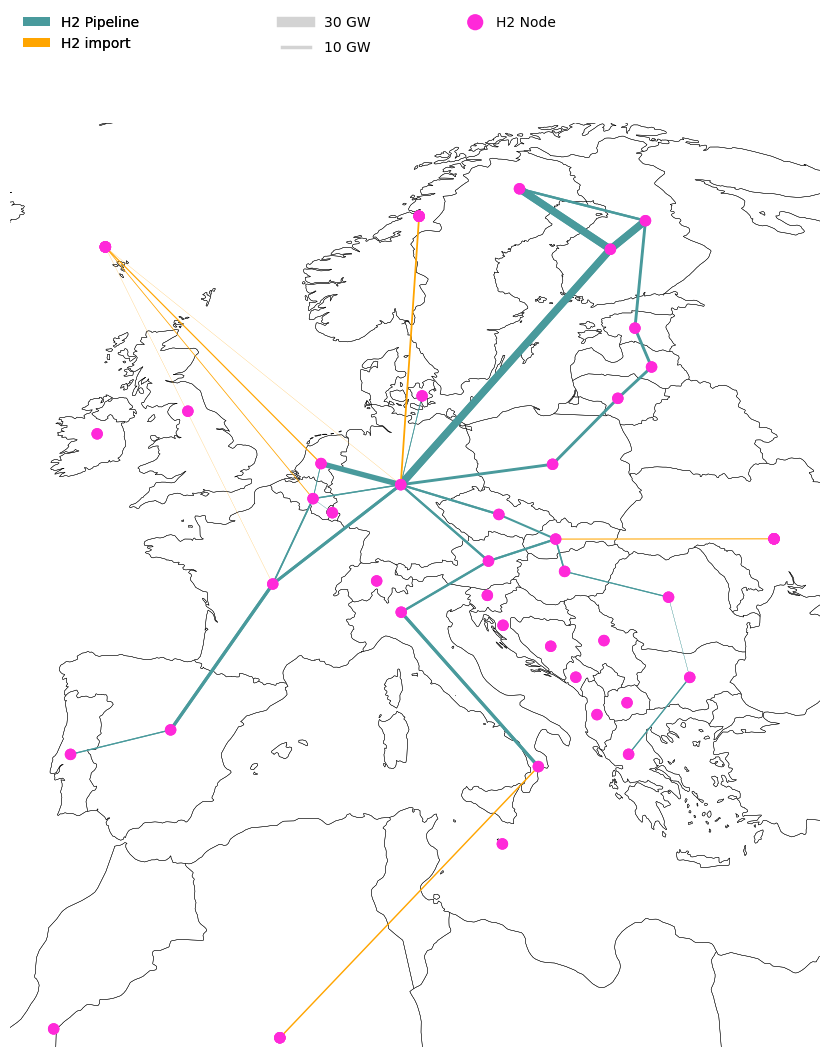

In [56]:
n = n_2030_NT_solved_lowres.copy()

def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


proj = load_projection(dict(name="EqualEarth"))

map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

if n.buses.country.isin(["MA", "DZ"]).any():
    map_opts["boundaries"] = list(np.add(map_opts["boundaries"], [0, 0, -6, 0]))

plot_h2_map_base(n, map_opts, proj)

# Benchmarking framework

In [57]:
# Present metrics used (incl. reference to methodology)
# Data sources used for comparison
# Mention introduction of onwind and solar
# Showcase current status
# --- Table
# --- Graphs

# Wrap up

In [58]:
# Collect feeback via Slido